## PUPPI @ L1T: Target studies

**GOAL**: Build a good (gen pT sum) / (reco pT sum) from PF candidats that can be used as a target for neutral regression in an ML-based model.

**NOTE**: gen and reco sums are computed in customised FastPUPPI perNano files and different cases can be tested in the current notebook:

* Gen numerators:
    * 'L1PuppiCands_genPtSum0p2',
    * 'L1PuppiCands_genNeutralPtSum0p2',
    * 'L1PuppiCands_genChargedPtSum0p2',
    * 'L1PuppiCands_genChargedHadPtSum0p2',
    * 'L1PuppiCands_genNeutralHadPtSum0p2'
    
* Reco denumerators:
    * 'L1PuppiCands_recoPtSum0p2',
    * 'L1PuppiCands_recoNeutralPtSum0p2',
    * 'L1PuppiCands_recoChargedPtSum0p2',
    * 'L1PuppiCands_recoChargedHadPtSum0p2',
    * 'L1PuppiCands_recoNeutralHadPtSum0p2'
    
**Running the notebook**: FastPUPPI perNano files are stored in eos. The current notebook can be run in SWAN to access the inputs.

In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm, Normalize
import seaborn as sb
from scipy.stats import binned_statistic

In [2]:
import mplhep as hep
plt.style.use(hep.style.ROOT)
hep.style.use(hep.style.CMS)

In [3]:
# Set PU under consideration
puVal = '200'

# Set radius used for the study
dR = '0p2' 

# Set outputdir
outdir = "plots"
#outdir = f"/eos/user/e/elfontan/www/PHASE2L1_Correlator/TARGETStudies/plots_PU{puVal}_EF"

# Ntuple with minimal thresholds of 1/2 GeV on neutrals/charged
# -------------------------------------------------------------------
infile = uproot.open(f'/eos/cms/store/cmst3/group/l1tr/elfontan/l1tPFplusPuppi/fp_ntuples_NNVtx_151X/TT_PU{puVal}/perfNano_PU{puVal}.root')

print("Input file = ", infile)

Input file =  <ReadOnlyDirectory '/' at 0x7f6c643996d0>


In [4]:
events = infile['Events;1']
branches = events.keys()

In [5]:
branches

['run',
 'luminosityBlock',
 'event',
 'bunchCrossing',
 'orbitNumber',
 'nTkEleL2',
 'TkEleL2_charge',
 'TkEleL2_hwQual',
 'TkEleL2_caloEta',
 'TkEleL2_caloPhi',
 'TkEleL2_eta',
 'TkEleL2_idScore',
 'TkEleL2_pfIso',
 'TkEleL2_pfIsoPV',
 'TkEleL2_phi',
 'TkEleL2_pt',
 'TkEleL2_puppiIso',
 'TkEleL2_puppiIsoPV',
 'TkEleL2_tkEta',
 'TkEleL2_tkIso',
 'TkEleL2_tkIsoPV',
 'TkEleL2_tkPhi',
 'TkEleL2_tkPt',
 'TkEleL2_vz',
 'nTkEmL2',
 'TkEmL2_hwQual',
 'TkEmL2_eta',
 'TkEmL2_pfIso',
 'TkEmL2_pfIsoPV',
 'TkEmL2_phi',
 'TkEmL2_pt',
 'TkEmL2_puppiIso',
 'TkEmL2_puppiIsoPV',
 'TkEmL2_tkIso',
 'TkEmL2_tkIsoPV',
 'nDecEmCaloBarrel',
 'DecEmCaloBarrel_hwEta',
 'DecEmCaloBarrel_hwPhi',
 'DecEmCaloBarrel_hwQual',
 'DecEmCaloBarrel_eta',
 'DecEmCaloBarrel_phi',
 'DecEmCaloBarrel_pt',
 'nDecEmCaloHGCalNoTK',
 'DecEmCaloHGCalNoTK_hwEta',
 'DecEmCaloHGCalNoTK_hwPhi',
 'DecEmCaloHGCalNoTK_hwQual',
 'DecEmCaloHGCalNoTK_eta',
 'DecEmCaloHGCalNoTK_phi',
 'DecEmCaloHGCalNoTK_pt',
 'nDecEmCaloHGCal',
 'DecEmCalo

In [6]:
#typ = 'PF'
typ = 'Puppi'

In [7]:
mask_neutral = np.abs(events[f'L1{typ}Cands_pdgId'].array()) == 130
#mask_neutral = np.abs(events[f'L1{typ}Cands_charge'].array()) == 0   #TESTED

mask_eta = np.abs(events[f'L1{typ}Cands_eta'].array()) < 1.4
#mask_eta = np.abs(events[f'L1{typ}Cands_eta'].array()) < 2.4         #TESTED

mask_genMatched = events[f'L1{typ}Cands_isGenMatched'].array() == 1

mask_neutral = mask_neutral & mask_eta
mask_neutral_matched = mask_neutral & mask_eta & mask_genMatched
mask_neutral_nonMatched = mask_neutral & mask_eta & ~mask_genMatched

#mask_neutral_genMatched = mask_neutral & mask_genMatched

## Reco sum

In [8]:
# Store ALL NUMERATORS with genSums
# -------------------------------------
branches_num = [
    b for b in branches
    if ("gen" in b) and (f"L1{typ}Cands" in b) and (dR in b) and not("genReco" in b)
]
branches_num

['L1PuppiCands_genPtSum0p2',
 'L1PuppiCands_genNeutralPtSum0p2',
 'L1PuppiCands_genChargedPtSum0p2',
 'L1PuppiCands_genChargedHadPtSum0p2',
 'L1PuppiCands_genNeutralHadPtSum0p2']

In [9]:
# Store ALL DENOMINATORS with recoSums
# -------------------------------------
branches_denom = [
    b for b in branches 
    if (f"L1{typ}Cands_reco" in b and f"{dR}" in b) 
]

branches_denom

['L1PuppiCands_recoPtSum0p2',
 'L1PuppiCands_recoNeutralPtSum0p2',
 'L1PuppiCands_recoChargedPtSum0p2',
 'L1PuppiCands_recoChargedHadPtSum0p2',
 'L1PuppiCands_recoNeutralHadPtSum0p2']

In [10]:
reco_pt = events[f'L1{typ}Cands_pt'].array()

#reco_pt = events['L1PuppiCands_pt'].array() * events['L1PuppiCands_puppiWeight'].array()

In [11]:
numerator = {}

for br in branches_num:
    numerator[br] = events[br].array()

In [12]:
denominator = {}

for br in branches_denom:
    denominator[br] = events[br].array()

In [ ]:
# ----------------------------------------------------------------------
# [SKIP] Compare several numerators against a SINGLE well-defined denominator
# ----------------------------------------------------------------------
"""
bins = np.linspace(0, 2, 100)
#bins = np.linspace(0, 1, 50)

denom = reco_pt[mask_neutral_matched]

for br in branches_num: 
    if 'Had' in br:
        continue

    plt.hist(ak.flatten(numerator[br][mask_neutral_matched]/denom), bins = bins, label=br, histtype='step', density=True)

plt.title('Denom: reco pt')
plt.legend()
"""

In [ ]:
# ----------------------------------------------------------------------
# [SKIP] Scan the effect of using different denominator definitions
# ----------------------------------------------------------------------
"""
bins = np.linspace(0, 2, 100)
#bins = np.linspace(0, 1, 50)

for idx in denominator.keys():
    denom = denominator[idx][mask_neutral]

    for br in branches_num:
    if 'Had' in br:
        continue
 
    plt.hist(ak.flatten(numerator[br][mask_neutral]/denom), bins = bins, label=br, histtype='step', density=True)

    plt.title(f'Denom: {idx}')
    plt.legend()
    
    plt.show()
"""

In [ ]:
# -------------------------------------------------------------------------------------------
# [GOOD ONE] Scan the effect of using different denominator definitions (+ PUPPI weight)
# -------------------------------------------------------------------------------------------
"""
bins = np.linspace(0, 2, 100)
#bins = np.linspace(0, 1, 50)

for idx in denominator.keys():
    denom = denominator[idx][mask_neutral_matched] 

    for br in branches_num:
        if 'genNeutralPt' not in br:
            continue
        if 'Had' in idx:
            continue
        
    plt.hist(ak.flatten(numerator[br][mask_neutral_matched]/denom), bins = bins, label=f'Gen ratio w/ Denom: {idx.split('_')[-1].split('0')[0]}', histtype='step', density=True)

plt.hist(ak.flatten(events[f'L1{typ}Cands_puppiWeight'].array()[mask_neutral_matched]), bins = bins, label=f'PUPPI weight', histtype='step', density=True)

plt.yscale('log')
plt.ylabel('A.U.')
plt.xlabel('Ratio of gen-sum to reco-sum')

plt.title(f'Numerator: all NEUTRAL gens in cone')
plt.legend()   
plt.show()
"""

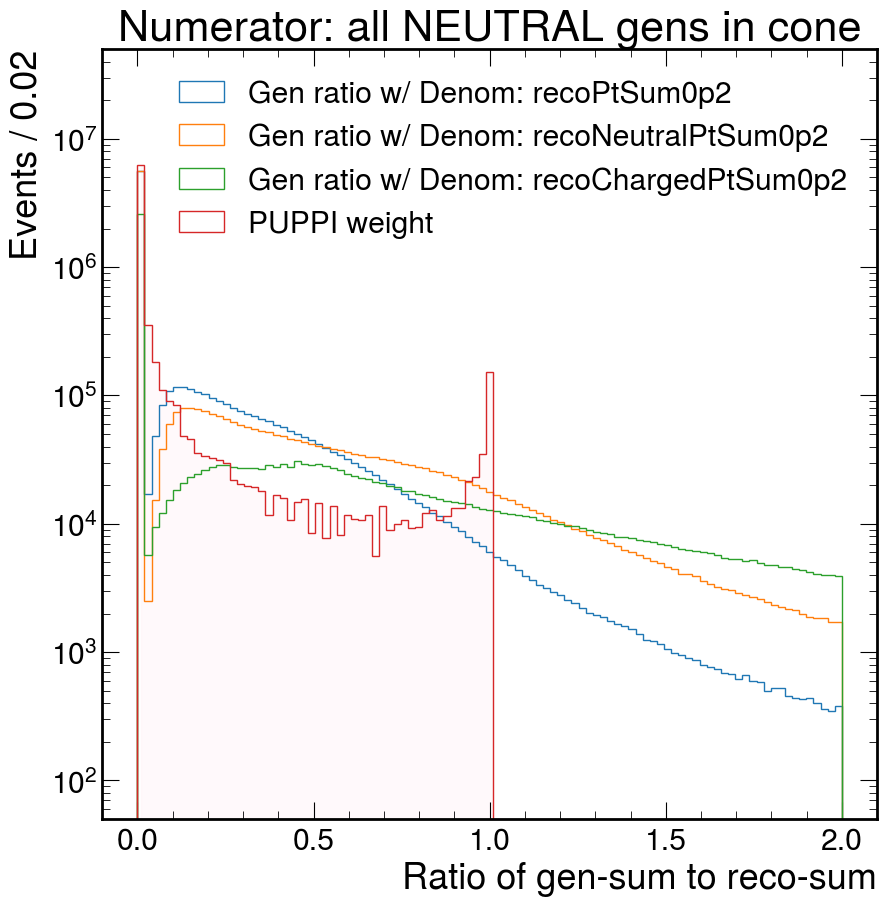

In [13]:
bins = np.linspace(0, 2, 100)
#bins = np.linspace(0, 1, 50)

for idx in denominator.keys():
    denom = denominator[idx][mask_neutral_matched]
    
    for br in branches_num:
        if 'genNeutralPt' not in br:
            continue
        if 'Had' in idx:
            continue

        num = numerator[br][mask_neutral_matched]

        # Capping at 1:
        # ---------------------------------------
        #plt.hist(ak.flatten(ak.where(numerator[br][mask_neutral_matched]/denom > 1, 1, numerator[br][mask_neutral_matched]/denom)), bins = bins, label=f'Gen ratio w/ Denom: {idx.split('_')[-1].split('0')[0]}', histtype='step', density=True)

        # No capping:
        # ---------------------------------------
        valid = denom > 0
        if ak.sum(valid) == 0:
            print(f"WARNING: all events with denominator = 0 per {idx}")
            continue

        ratio = num[valid] / denom[valid]
        ratio_flat = ak.to_numpy(ak.flatten(ratio))

        plt.hist(
            ratio_flat,
            bins=bins,
            histtype="step",
            #density=True,
            label=f"Gen ratio w/ Denom: {idx.split('_')[-1]}"
        )

        
# Plot del PUPPI weight
# ---------------------
w = ak.to_numpy(ak.flatten(events[f'L1{typ}Cands_puppiWeight'].array()[mask_neutral_matched]))
#plt.hist(
#   w, 
#    bins=bins, 
#    histtype="step", 
#    #density=True, 
#    label="PUPPI weight"
#)

vals, edges, _ = plt.hist(
    w, 
    bins=bins, 
    histtype="step",
    label="PUPPI weight"
)

# Compute bin centers
centers = 0.5 * (edges[:-1] + edges[1:])
# Filling
plt.fill_between(
    centers,
    vals,
    step="mid",
    alpha=0.40,    
    color="lavenderblush" #"bisque"
)

#plt.ylabel('A.U.')
plt.ylabel('Events / 0.02')
plt.xlabel('Ratio of gen-sum to reco-sum')
plt.yscale('log')
plt.ylim([50, 50000000])

plt.title('Numerator: all NEUTRAL gens in cone')
plt.legend()
#plt.show()
plt.savefig(f"{outdir}/allNeutralGensInCone_ratio_PU{puVal}_dR{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/allNeutralGensInCone_ratio_PU{puVal}_dR{dR}.png", dpi=300)

/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:290: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:290: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


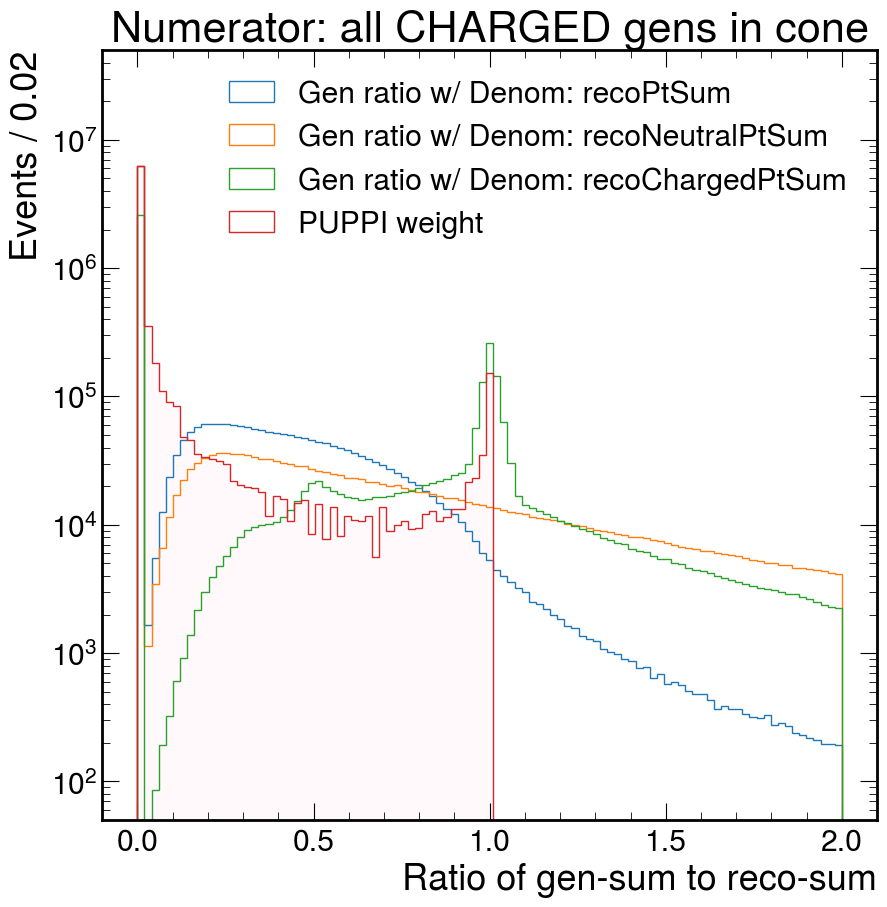

In [14]:
bins = np.linspace(0, 2, 100)

for idx in denominator.keys():
    denom = denominator[idx][mask_neutral_matched] 

    for br in branches_num:
        if 'genChargedPt' not in br:
            continue
        if 'Had' in idx:
            continue
        
        plt.hist(
            ak.flatten(numerator[br][mask_neutral_matched]/denom), 
            bins = bins, 
            label=f'Gen ratio w/ Denom: {idx.split('_')[-1].split('0')[0]}', 
            histtype='step', 
            #density=True
        )

# Plot del PUPPI weight
# ---------------------
vals, edges, _ = plt.hist(
    ak.flatten(events[f'L1{typ}Cands_puppiWeight'].array()[mask_neutral_matched]), 
    bins = bins, 
    label=f'PUPPI weight', 
    histtype='step', 
    #density=True
)

# Compute bin centers
centers = 0.5 * (edges[:-1] + edges[1:])
# Filling
plt.fill_between(
    centers,
    vals,
    step="mid",
    alpha=0.40,    
    color="lavenderblush" #"bisque"
)


#plt.ylabel('A.U.')
#plt.ylim([3e-2, 5e+1])
plt.ylabel('Events / 0.02')
plt.xlabel('Ratio of gen-sum to reco-sum')
plt.yscale('log')
plt.ylim([50, 50000000])

plt.title(f'Numerator: all CHARGED gens in cone')
plt.legend()   
#plt.show()
plt.savefig(f"{outdir}/allChargedGensInCone_ratio_PU{puVal}_dR{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/allChargedGensInCone_ratio_PU{puVal}_dR{dR}.png", dpi=300)

/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:290: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:290: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


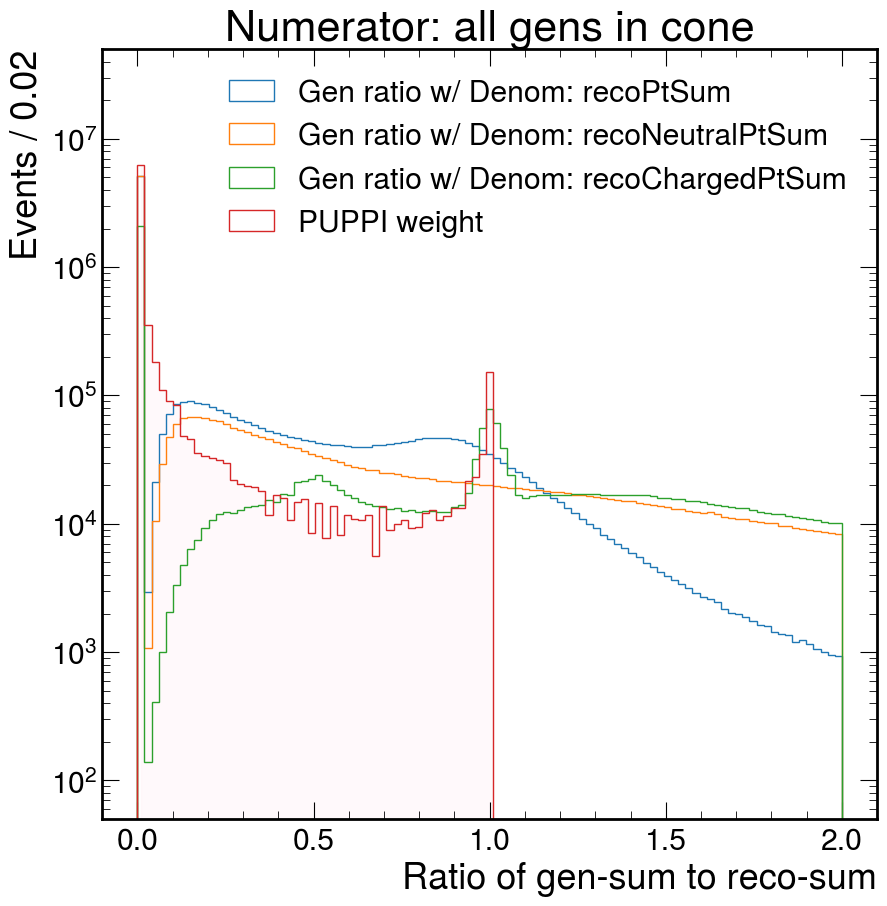

In [15]:
bins = np.linspace(0, 2, 100)

for idx in denominator.keys():
    denom = denominator[idx][mask_neutral_matched]

    for br in branches_num:
        if 'genPt' not in br:
            continue
        if 'Had' in idx:
            continue
    
        plt.hist(
            ak.flatten(numerator[br][mask_neutral_matched]/denom), 
            bins = bins, 
            label=f'Gen ratio w/ Denom: {idx.split('_')[-1].split('0')[0]}', 
            histtype='step', 
            #density=True
        )

# Plot del PUPPI weight
# ---------------------
vals, edges, _ = plt.hist(
    ak.flatten(events[f'L1{typ}Cands_puppiWeight'].array()[mask_neutral_matched]), 
    bins = bins, 
    label=f'PUPPI weight', 
    histtype='step', 
    #density=True
)

# Compute bin centers
centers = 0.5 * (edges[:-1] + edges[1:])
# Filling
plt.fill_between(
    centers,
    vals,
    step="mid",
    alpha=0.40,    
    color="lavenderblush" #"bisque"
)

#plt.ylim([3e-2, 5e+1])
#plt.ylabel('A.U.')
plt.ylabel('Events / 0.02')
plt.xlabel('Ratio of gen-sum to reco-sum')
plt.yscale('log')
plt.ylim([50, 50000000])

plt.title(f'Numerator: all gens in cone')
plt.legend()   
#plt.show()
plt.savefig(f"{outdir}/allGensInCone_ratio_PU{puVal}_dR{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/allGensInCone_ratio_PU{puVal}_dR{dR}.png", dpi=300)

## Multiplicities

In [16]:
color_key = ['blue', 'green', 'red']

bins = range(10)

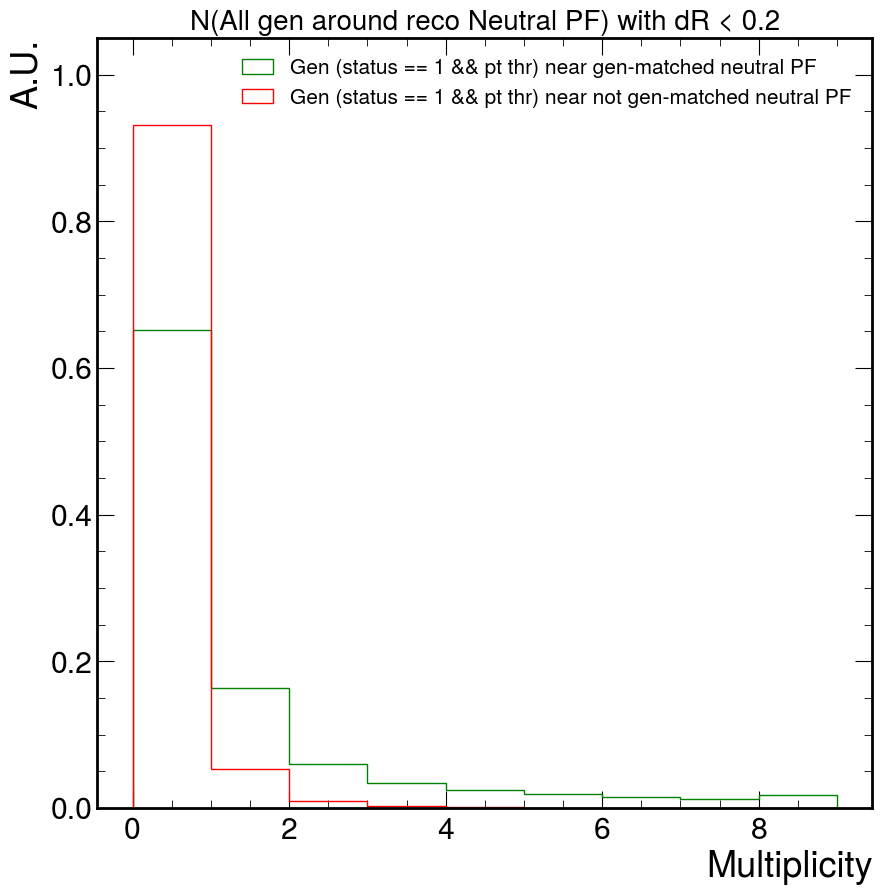

In [17]:
cut = 'nGen'

branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1PtThrIn' in b)] 

map_key = {
    f'{cut}Status1PtThrInCone{dR}': 'status == 1 && pt thr', 
    
}

line_key = {
    f'{cut}Status1PtThrInCone{dR}': '-',
}

for idx, br in enumerate(branches_num):
    plt.hist(ak.flatten(events[br].array()[mask_neutral_matched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+1], density=True)
    plt.hist(ak.flatten(events[br].array()[mask_neutral_nonMatched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near not gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+2], density=True)

plt.xlabel("Multiplicity")
plt.ylabel('A.U.')
plt.ylim([0,1.05])
plt.title(f'N(All gen around reco Neutral PF) with dR < {dR.replace("p",".")}', fontsize=20)
plt.legend(fontsize=15)

plt.savefig(f"{outdir}/nGenPtThr_multiplicity_dr{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/nGenPtThr_multiplicity_dr{dR}.png", dpi=300)

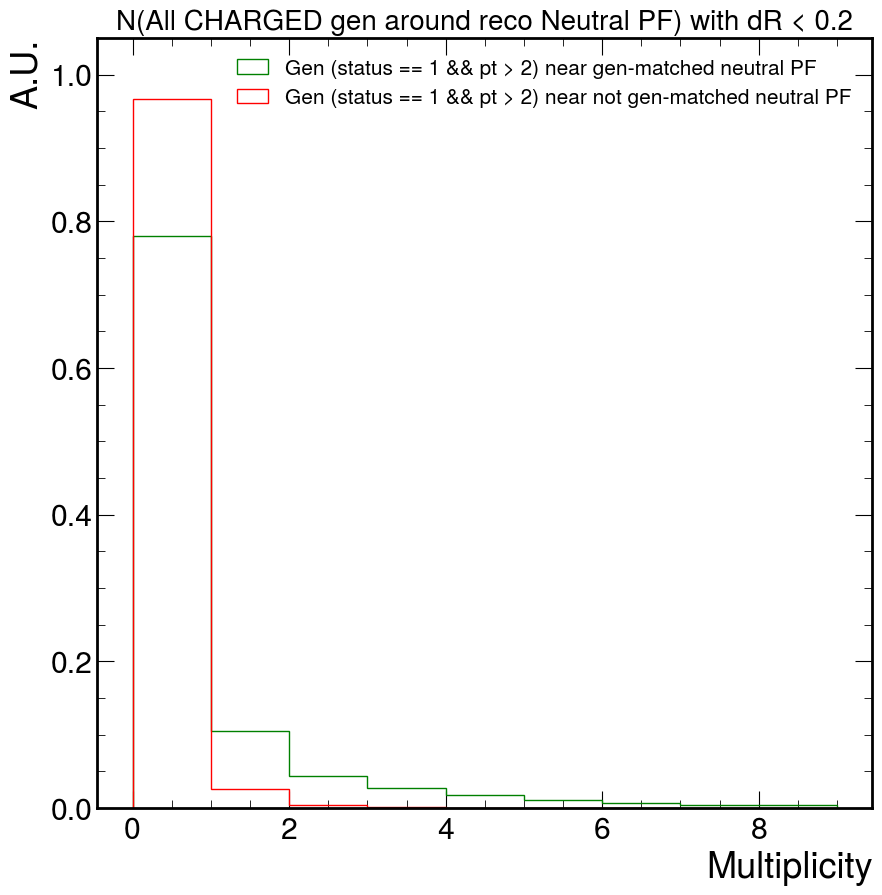

In [18]:
cut = 'nChargedGen'

branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1Pt2In' in b)] 

map_key = {
    f'{cut}Status1Pt2InCone{dR}': 'status == 1 && pt > 2',
}

line_key = {
    f'{cut}Status1Pt2InCone{dR}': '-', 
}

for idx, br in enumerate(branches_num):
    plt.hist(ak.flatten(events[br].array()[mask_neutral_matched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+1], density=True)
    plt.hist(ak.flatten(events[br].array()[mask_neutral_nonMatched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near not gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+2], density=True)

plt.xlabel("Multiplicity")
plt.ylabel('A.U.')
plt.title(f'N(All CHARGED gen around reco Neutral PF) with dR < {dR.replace("p",".")}', fontsize=20)
plt.legend(fontsize=15)
plt.ylim([0,1.05])

plt.savefig(f"{outdir}/nChargedGenPt2_multiplicity_dr{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/nChargedGenPt2_multiplicity_dr{dR}.png", dpi=300)

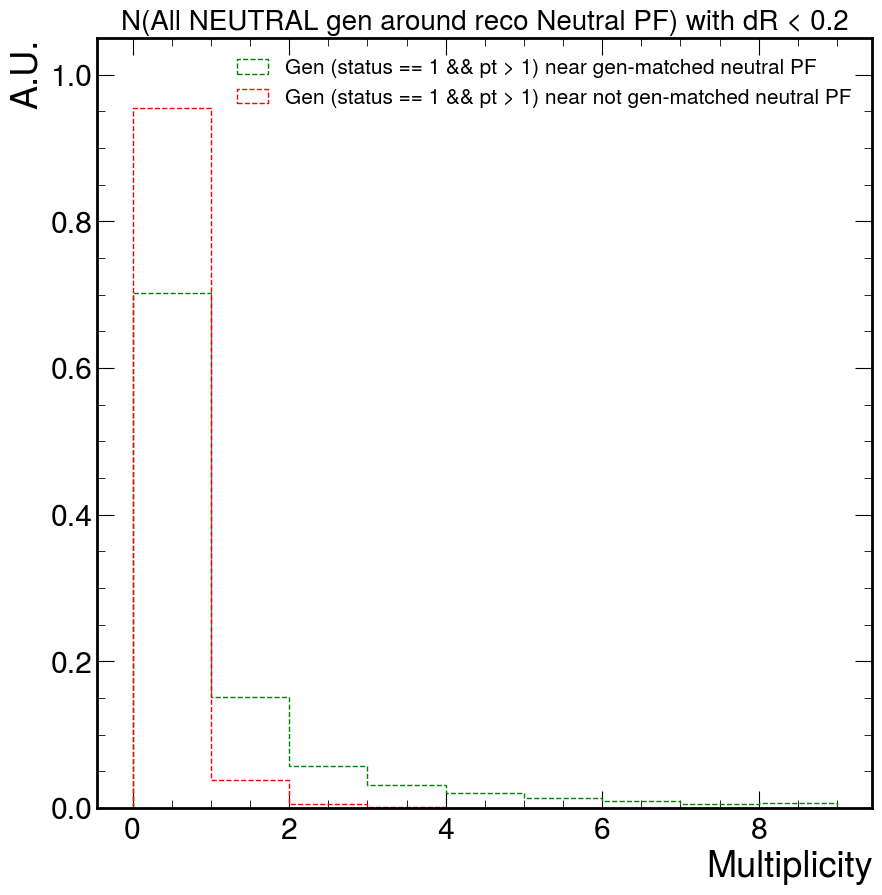

In [19]:
cut = 'nNeutralGen'

branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1Pt1In' in b)] 


map_key = {
    f'{cut}Status1InCone{dR}': 'status == 1',
    f'{cut}Status1Pt1InCone{dR}': 'status == 1 && pt > 1',

}

line_key = {
    f'{cut}Status1Pt1InCone{dR}': '--', 
}

for idx, br in enumerate(branches_num):
    plt.hist(ak.flatten(events[br].array()[mask_neutral_matched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+1], density=True)
    plt.hist(ak.flatten(events[br].array()[mask_neutral_nonMatched]), bins = bins, label=f'Gen ({map_key[br.split('_')[-1]]}) near not gen-matched neutral PF', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx+2], density=True)

plt.xlabel("Multiplicity")
plt.ylabel('A.U.')
plt.ylim([0,1.05])
plt.title(f'N(All NEUTRAL gen around reco Neutral PF) with dR < {dR.replace("p",".")}', fontsize=20)
plt.legend(fontsize=15)

plt.savefig(f"{outdir}/nNeutralGenPt1_multiplicity_dr{dR}.pdf", dpi=300)
plt.savefig(f"{outdir}/nNeutralGenPt1_multiplicity_dr{dR}.png", dpi=300)

In [ ]:
"""
cut = 'nGen'

for idx, dR in enumerate(['0p2','0p3']):
    branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1PtThrIn' in b)]

    map_key = {
        f'{cut}Status1PtThrInCone{dR}': 'status == 1 && pt thresholds'
    }

    line_key = {
        f'{cut}Status1PtThrInCone{dR}': '--'
    }

    for br in branches_num:
        plt.hist(ak.flatten(events[br].array()[mask_neutral]), bins = bins, label=f'dR < {dR.replace("p",".")}: {map_key[br.split('_')[-1]]}', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx], density=True)
    
plt.ylabel('A.U.')
plt.title(f'# All gen around reco Neutral PF')
plt.legend()
"""

In [ ]:
"""
cut = 'nChargedGen'

for idx, dR in enumerate(['0p2','0p3']):
    branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1Pt2' in b)]

    map_key = {
        f'{cut}Status1Pt2InCone{dR}': 'status == 1 && pt > 2'
    }

    line_key = {
        f'{cut}Status1Pt2InCone{dR}': '--'
    }

    for br in branches_num:
        plt.hist(ak.flatten(events[br].array()[mask_neutral]), bins = bins, label=f'dR < {dR.replace("p",".")}: {map_key[br.split('_')[-1]]}', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx], density=True)
    
plt.ylabel('A.U.')
plt.title(f'# All Charged gen (charge != 0) around reco Neutral PF')
plt.legend()
"""

In [ ]:
"""
cut = 'nNeutralGen'

for idx, dR in enumerate(['0p2','0p3']):
    branches_num = [b for b in branches if ("Gen" in b) and ((f"L1{typ}Cands" in b) and (dR in b)) and (cut in b) and ('Status1Pt1' in b)]

    map_key = {
        f'{cut}Status1Pt1InCone{dR}': 'status == 1 && pT > 1'
    }

    line_key = {
        f'{cut}Status1Pt1InCone{dR}': '--'
    }

    for br in branches_num:
        plt.hist(ak.flatten(events[br].array()[mask_neutral]), bins = bins, label=f'dR < {dR.replace("p",".")}: {map_key[br.split('_')[-1]]}', histtype='step', linestyle=line_key[br.split('_')[-1]], color=color_key[idx], density=True)
    
plt.ylabel('A.U.')
plt.title(f'# All Neutral gen (charge == 0) around reco Neutral PF')
plt.legend()
"""

## Outdated: testing parts of code

In [ ]:
def match_denom(gen_branches, denom_branches, dR):
    mapping = {}

    # ordered priority from most specific to fallback
    keys = [
        ("NeutralPtSum0p2", "recoNeutralPtSum"),
        ("ChargedPtSum0p2", "recoChargedPtSum"),
        ("ChargedHadPtSum", "recoChargedHadPtSum"),
        ("NeutralHadPtSum", "recoNeutralHadPtSum"),
        ("PtSum0p2", "recoPtSum"),
    ]

    for g in gen_branches:
        matched = None
        for gen_key, reco_key in keys:
            if gen_key in g:
                # find RECO with same ΔR
                candidates = [
                    d for d in denom_branches
                    if (reco_key in d) and (d.endswith(dR))
                ]
                if candidates:
                    matched = candidates[0]
                    break

        if matched is None:
            print(f"WARNING: no denominator match for {g}")

        mapping[g] = matched

    return mapping


# --- Build mapping ---
mapping = match_denom(branches_num, branches_denom, dR="0p2")
for g, d in mapping.items():
    print(f"{g:65s} --> {d}")

In [ ]:
bins = np.linspace(0, 2, 100)

den_keys_filtered = [k for k in denominator.keys() if "Had" not in k]

# Choose numerators with "Status1Pt" and no "Had"
num_keys_filtered = [k for k in numerator.keys() if ("PtSum" in k and "Had" not in k)]

for denom_key in den_keys_filtered:
    denom = denominator[denom_key][mask_neutral_matched]
    
    plt.figure(figsize=(12,9))
    
    for num_key in num_keys_filtered:
        num = numerator[num_key][mask_neutral_matched]
        
        valid = denom > 0
        if ak.sum(valid) == 0:
            print(f"WARNING: all events with denominator = 0 for {denom_key}")
            continue

        ratio = num[valid] / denom[valid]
        ratio_flat = ak.to_numpy(ak.flatten(ratio))
        
        plt.hist(
            ratio_flat,
            bins=bins,
            histtype="step",
            label=num_key
        )
        
    # Plot PUPPI weight for comparison
    w = ak.to_numpy(ak.flatten(events[f"L1{typ}Cands_puppiWeight"].array()[mask_neutral_matched]))
    plt.hist(w, bins=bins, histtype="step", label="PUPPI weight")
    
    plt.yscale('log')
    plt.xlabel('Ratio of gen-sum to reco-sum')
    plt.title(f"Denom: {denom_key}")
    plt.legend(fontsize=15)
    #plt.show()
    #plt.savefig(f"{oudir}/ratios_{denom_key}_0to2_log_noAU.pdf", dpi=300)
    #plt.savefig(f"{oudir}/ratios_{denom_key}_0to2_log_noAU.png", dpi=300)
